In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [3]:
%matplotlib inline

from session.sessions import selected_009266
from imports import *
from loading import load_session_data
from target import get_spike_counts, build_tgt_matrix, build_silence_matrix
from scipy import stats
from scipy import signal
import pandas as pd
from functools import reduce
from statsmodels.formula.api import ols, glm
from postprocessing.spiketrain import instantaneous_rate

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
selected_009266

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_09-11-06',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

## Computing GLM fit for selected sessions with AL state

In [65]:
AL_units = ['3-15', '3-4', '3-18', '3-18', '4-2', '3-9']
selected_idxs = [4, 5, 6, 7, 8, 9]
selected_sessions = [selected_009266[i] for i in selected_idxs]

In [66]:
win_l   = 2    # seconds
step    = 1    # seconds
s_rate  = 100  # Hz
syl_num = 10

coeffs = np.zeros([len(selected_sessions), syl_num + 1])  # + intercept
p_vals = np.zeros([len(selected_sessions), syl_num + 1])  # + intercept
for i, session in enumerate(selected_sessions):
    session_data = load_session_data(session)
    tl = session_data['tl']

    # load moseq data
    animal     = session.split('_')[0]
    moseq_file = os.path.join(source, animal, session, 'moseq.h5')
    with h5py.File(moseq_file, 'r') as f:
        moseq_matrix  = np.array(f['moseq'])
        moseq_headers = f['moseq'].attrs['headers']
    moseq_headers = moseq_headers.split(',')
    moseq_headers = [moseq_headers[0]] + [x[1:] for x in moseq_headers[1:]]
    moseq = pd.DataFrame(moseq_matrix, columns=moseq_headers)

    # build syllable ratio matrix
    idxs_srm_tl = np.arange(0, len(tl), step*s_rate)
    syl_ratio_matrix = np.zeros([len(idxs_srm_tl), syl_num])
    for k, idx in enumerate(idxs_srm_tl):
        curr_syls = moseq['syllables reindexed'][idx:idx + win_l*s_rate]
        for j in np.arange(syl_num):
            syl_ratio_matrix[k, j] = np.sum(curr_syls == j) / (win_l*s_rate)
            
    # state defined by AL unit 
    unit = AL_units[i]
    i_rate = session_data['single_units'][unit]
    i_rate_binned = i_rate[idxs_srm_tl]  # AL unit

    # GLM
    data = np.column_stack([i_rate_binned, syl_ratio_matrix])
    columns = ['state'] + ["x%d" % x for x in range(syl_ratio_matrix.shape[1])]
    syl_ratio_df = pd.DataFrame(data, columns=columns)

    model = glm('state ~ ' + ' + '.join(columns[1:]), data=syl_ratio_df).fit()
    coeffs[i] = np.array(model.params)
    p_vals[i] = np.array(model.pvalues)

    print("Session %s done" % session)

Session 009266_hippoSIT_2023-04-20_08-57-39 done
Session 009266_hippoSIT_2023-04-20_15-24-14 done
Session 009266_hippoSIT_2023-04-21_08-43-00 done
Session 009266_hippoSIT_2023-04-21_13-12-31 done
Session 009266_hippoSIT_2023-04-24_10-08-11 done
Session 009266_hippoSIT_2023-04-24_16-56-55 done


[6.055348347851935,
 7.061025027719134,
 -6.466607965548154,
 3.0941955075432723,
 14.790756771641767]

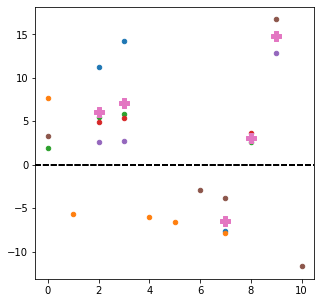

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, coeff in enumerate(coeffs):
    idxs_p = np.where(p_vals[i] < 0.01)[0]
    lbl = selected_sessions[i][-12:]
    ax.scatter(np.arange(len(coeff))[idxs_p], coeff[idxs_p], s=20, label=lbl)
    ax.axhline(0, ls='--', color='black')
    #ax.legend(loc='lower left')
    
syl_idxs = []
glm_means = []
for i in np.arange(coeffs.shape[1] - 1) + 1:  # exclude intercept
    if not (p_vals[:, i] < 0.01).sum() > 1:
        continue
    glm_means.append(coeffs[:, i][p_vals[:, i] < 0.01].mean())
    syl_idxs.append(i)
    
#ax.plot(np.arange(coeffs.shape[1]), coeffs.mean(axis=0))
ax.scatter(syl_idxs, glm_means, marker='P', s=100)
glm_means

## Save behavioral fits for AL states

In [70]:
to_save = list(selected_009266)
to_save.remove('009266_hippoSIT_2023-05-04_09-11-06')

In [78]:
win_l   = 2    # seconds
step    = 1    # seconds
s_rate  = 100  # Hz
syl_num = 10

# idx / coeff for GLM fit for AL
glm_coeffs = {1: 6.05, 2: 7.06, 6: -6.46, 7: 3.09, 8: 14.79}

for i, session in enumerate(to_save):
    session_data = load_session_data(session)
    tl = session_data['tl']

    # load moseq data
    animal     = session.split('_')[0]
    moseq_file = os.path.join(source, animal, session, 'moseq.h5')
    with h5py.File(moseq_file, 'r') as f:
        moseq_matrix  = np.array(f['moseq'])
        moseq_headers = f['moseq'].attrs['headers']
    moseq_headers = moseq_headers.split(',')
    moseq_headers = [moseq_headers[0]] + [x[1:] for x in moseq_headers[1:]]
    moseq = pd.DataFrame(moseq_matrix, columns=moseq_headers)

    # build syllable ratio matrix
    idxs_srm_tl = np.arange(0, len(tl), step*s_rate)
    syl_ratio_matrix = np.zeros([len(idxs_srm_tl), syl_num])
    for k, idx in enumerate(idxs_srm_tl):
        curr_syls = moseq['syllables reindexed'][idx:idx + win_l*s_rate]
        for j in np.arange(syl_num):
            syl_ratio_matrix[k, j] = np.sum(curr_syls == j) / (win_l*s_rate)
            
    behav_fit = np.zeros(len(syl_ratio_matrix))
    for idx, coef in glm_coeffs.items():
        behav_fit += coef * syl_ratio_matrix[:, idx]
        
    behav_fit_AL = np.column_stack([idxs_srm_tl, behav_fit])
    with h5py.File(moseq_file, 'a') as f:
        if 'behav_fit_AL' in f:
            del f['behav_fit_AL']
        ds_h5 = f.create_dataset('behav_fit_AL', data=behav_fit_AL)
        ds_h5.attrs['headers'] = 'tl_idxs, behav_fit_AL'
        
    print("Session %s done" % session)

## quick test

In [82]:
for i, session in enumerate(selected_sessions):
    moseq_file = os.path.join(source, animal, session, 'moseq.h5')
    with h5py.File(moseq_file, 'r') as f:
        behav_fit_AL = np.array(f['behav_fit_AL'])
        
    session_data = load_session_data(session)
    unit = AL_units[i]
    i_rate = session_data['single_units'][unit]
    #i_rate_binned = i_rate[idxs_srm_tl]  # AL unit
    
    idxs = behav_fit_AL[:, 0].astype(np.int32)
    print(stats.pearsonr(i_rate[idxs], behav_fit_AL[:, 1]))

(0.6156134479838558, 2.270042919564018e-250)
(0.5625977950506312, 1.6509655668876485e-200)
(0.4773896123630794, 7.120456829975116e-137)
(0.43527495264866933, 1.5497133285264937e-111)
(0.41277815367407955, 2.1277002580474566e-99)
(0.30548938896014843, 5.1340398029625e-53)


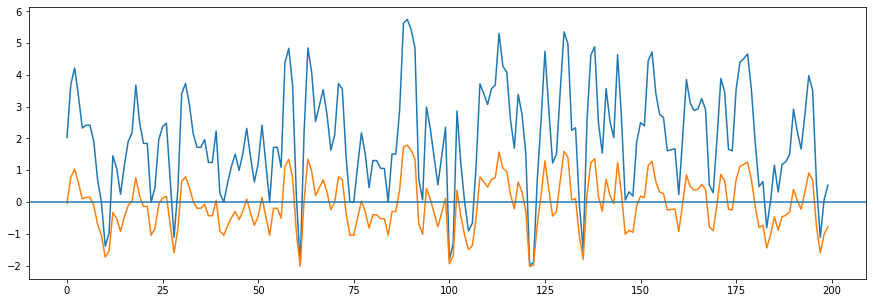

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(behav_fit_AL[:, 1][:200])
ax.plot(stats.zscore(behav_fit_AL[:, 1])[:200])
ax.axhline(0)